In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import math

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### change cab_type to binary value 

In [4]:
train['cab_type'] = train['cab_type'].replace({'Uber':1,'Lyft':0})

In [7]:
train.head(3)

,distance,cab_type,time_stamp,price,surge_multiplier,temp_source,clouds_source,pressure_source,rain_source,humidity_source,...,nm_Lux,nm_Lux Black,nm_Lux Black XL,nm_Lyft,nm_Lyft XL,nm_Shared,nm_UberPool,nm_UberX,nm_UberXL,nm_WAV
0,3.44,1,1543244710344,17.0,1.0,39.394092,0.677495,1008.438031,0.008310,0.755468,...,0,0,0,0,0,0,0,0,0,1
1,2.49,0,1543616288459,16.5,1.0,39.047285,0.677801,1008.448356,0.008297,0.765048,...,1,0,0,0,0,0,0,0,0,0
2,1.11,1,1543411028318,26.0,1.0,39.090841,0.676730,1008.441912,0.008644,0.764054,...,0,0,0,0,0,0,0,0,0,0


## WEATHER -- create indicator value for strength of wind/rain/humidity

## WIND

In [19]:
wd25, wd50, wd75 = train['wind_destination'].quantile([0.25, 0.5, 0.75])
ws25, ws50, ws75 = train['wind_source'].quantile([0.25, 0.5, 0.75])

In [21]:
# wind destination 
train.loc[train['wind_destination'] < wd25, 'wind_d_strength'] = 1
train.loc[((train['wind_destination'] < wd50) & (train['wind_destination'] >= wd25)), 'wind_d_strength'] = 2
train.loc[((train['wind_destination'] < wd75) & (train['wind_destination'] >= wd50)), 'wind_d_strength'] = 3
train.loc[train['wind_destination'] >= wd75, 'wind_d_strength'] = 4

In [35]:
# wind source 
train.loc[train['wind_source'] < ws25, 'wind_s_strength'] = 1
train.loc[((train['wind_source'] < ws50) & (train['wind_source'] >= ws25)), 'wind_s_strength'] = 2
train.loc[((train['wind_source'] < ws75) & (train['wind_source'] >= ws50)), 'wind_s_strength'] = 3
train.loc[train['wind_source'] >= ws75, 'wind_s_strength'] = 4

<AxesSubplot:xlabel='wind_s_strength', ylabel='price'>

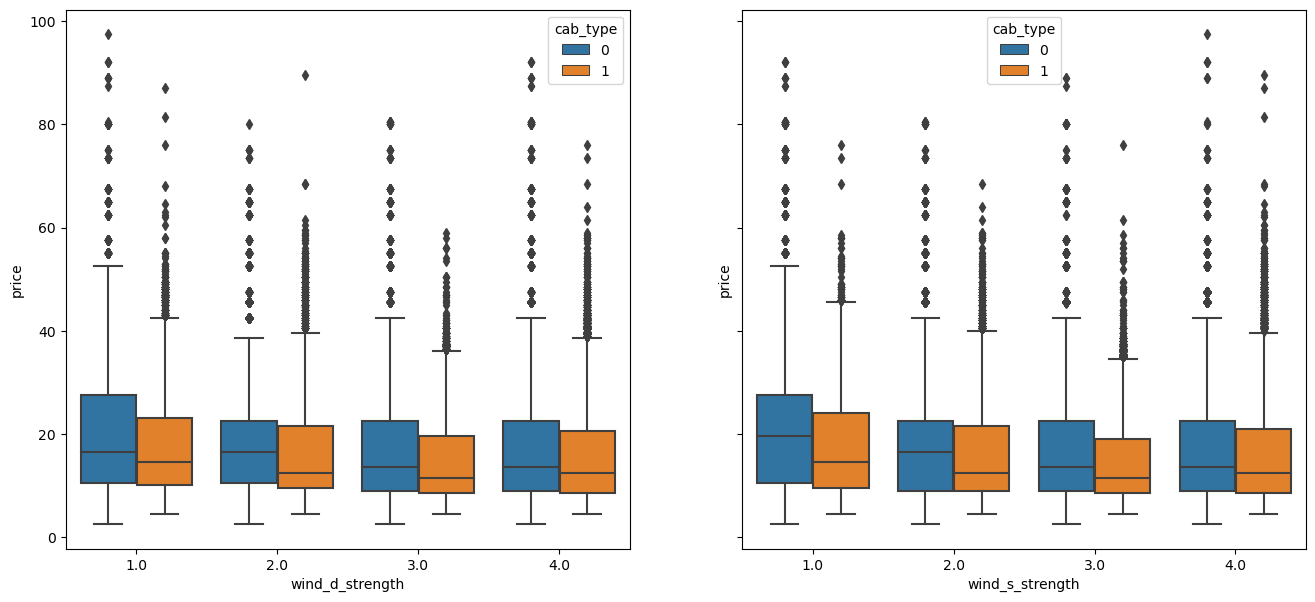

In [69]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax=ax[0], data = train, x = 'wind_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax=ax[1], data = train, x = 'wind_s_strength', y = 'price', hue = 'cab_type')

#### remove outliers

#### conclusion: prices of ubers were marginally higher for when wind_strength was 1 (its lowest), however, it does appear that in general at every rain strength, cab_type 1 (Uber) offers a lower price

## RAIN

In [30]:
rd25, rd50, rd75 = train['rain_destination'].quantile([0.25, 0.5, 0.75])
rs25, rs50, rs75 = train['rain_source'].quantile([0.25, 0.5, 0.75])

In [33]:
# rain destination 
train.loc[train['rain_destination'] < rd25, 'rain_d_strength'] = 1
train.loc[((train['rain_destination'] < rd50) & (train['rain_destination'] >= rd25)), 'rain_d_strength'] = 2
train.loc[((train['rain_destination'] < rd75) & (train['rain_destination'] >= rd50)), 'rain_d_strength'] = 3
train.loc[train['rain_destination'] >= rd75, 'rain_d_strength'] = 4

In [38]:
# rain source 
train.loc[train['rain_source'] < rs25, 'rain_s_strength'] = 1
train.loc[((train['rain_source'] < rs50) & (train['rain_source'] >= rs25)), 'rain_s_strength'] = 2
train.loc[((train['rain_source'] < rs75) & (train['rain_source'] >= rs50)), 'rain_s_strength'] = 3
train.loc[train['rain_source'] >= rs75, 'rain_s_strength'] = 4

<AxesSubplot:xlabel='rain_s_strength', ylabel='price'>

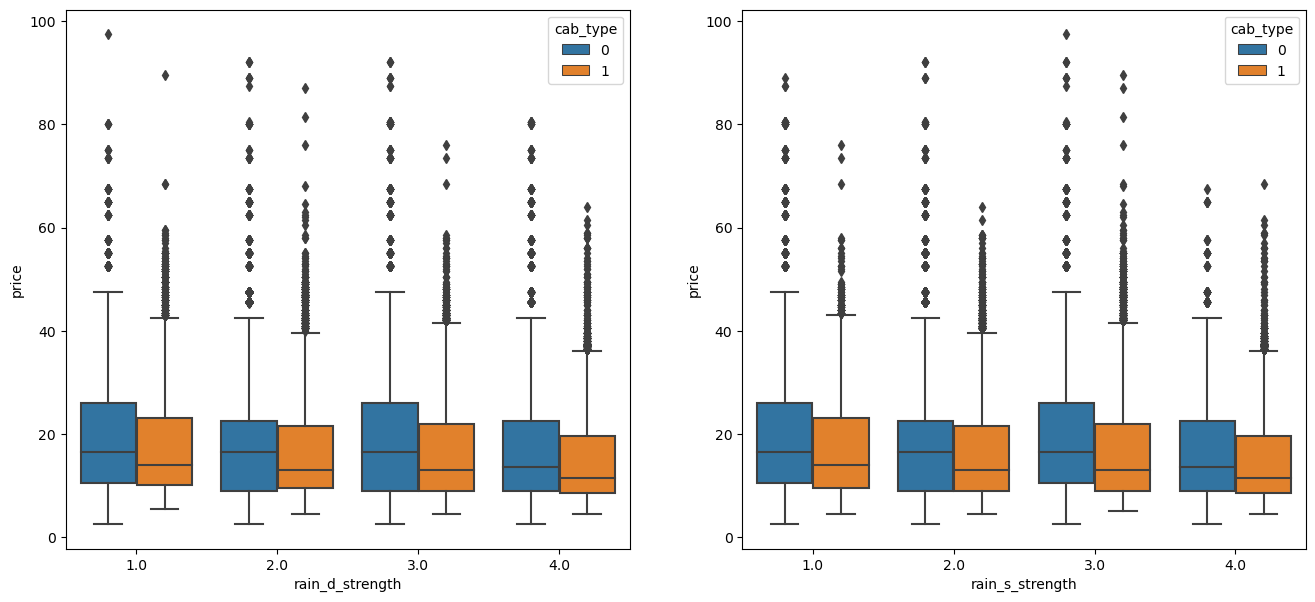

In [76]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'rain_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax = ax[1], data = train, x = 'rain_s_strength', y = 'price', hue = 'cab_type')

#### remove outliers

In [47]:
rainnooutliers = train[train['price'] <45] # super approximate removal of outliers

rd25, rd50, rd75 = rainnooutliers['rain_destination'].quantile([0.25, 0.5, 0.75])
rs25, rs50, rs75 = rainnooutliers['rain_source'].quantile([0.25, 0.5, 0.75])

# rain destination 
rainnooutliers.loc[rainnooutliers['rain_destination'] < rd25, 'rain_d_strength'] = 1
rainnooutliers.loc[((rainnooutliers['rain_destination'] < rd50) & (rainnooutliers['rain_destination'] >= rd25)), 'rain_d_strength'] = 2
rainnooutliers.loc[((rainnooutliers['rain_destination'] < rd75) & (rainnooutliers['rain_destination'] >= rd50)), 'rain_d_strength'] = 3
rainnooutliers.loc[rainnooutliers['rain_destination'] >= rd75, 'rain_d_strength'] = 4


<AxesSubplot:xlabel='rain_s_strength', ylabel='price'>

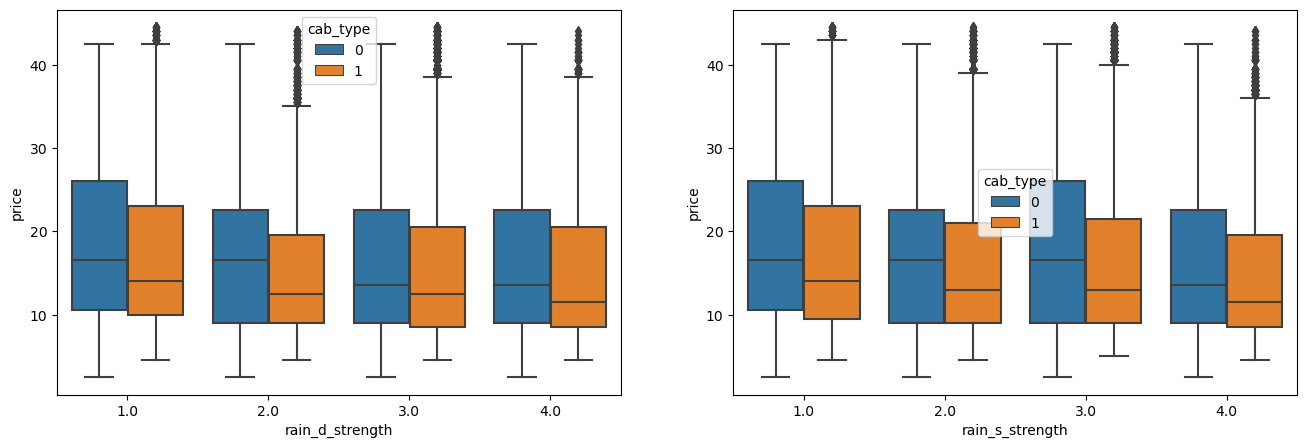

In [75]:
fig, ax =plt.subplots(1,2, figsize=(16, 5))
sns.boxplot(ax=ax[0],data = rainnooutliers, x = 'rain_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax=ax[1],data = rainnooutliers, x = 'rain_s_strength', y = 'price', hue = 'cab_type')


#### conclusion: doesn't seem to be a huge correlation between rain strength and price of ride. however, it does appear that in general at every rain strength, cab_type 1 (Uber) offers a lower price

## HUMIDITY

In [55]:
hd25, hd50, hd75 = train['humidity_destination'].quantile([0.25, 0.5, 0.75])
hs25, hs50, hs75 = train['humidity_source'].quantile([0.25, 0.5, 0.75])

In [77]:
# humidity destination 
train.loc[train['humidity_destination'] < hd25, 'humidity_d_strength'] = 1
train.loc[((train['humidity_destination'] < hd50) & (train['humidity_destination'] >= hd25)), 'humidity_d_strength'] = 2
train.loc[((train['humidity_destination'] < hd75) & (train['humidity_destination'] >= hd50)), 'humidity_d_strength'] = 3
train.loc[train['humidity_destination'] >= hd75, 'humidity_d_strength'] = 4

In [78]:
# humidity source 
train.loc[train['humidity_source'] < hd25, 'humidity_s_strength'] = 1
train.loc[((train['humidity_source'] < hd50) & (train['humidity_source'] >= hd25)), 'humidity_s_strength'] = 2
train.loc[((train['humidity_source'] < hd75) & (train['humidity_source'] >= hd50)), 'humidity_s_strength'] = 3
train.loc[train['humidity_source'] >= hd75, 'humidity_s_strength'] = 4

<AxesSubplot:xlabel='humidity_s_strength', ylabel='price'>

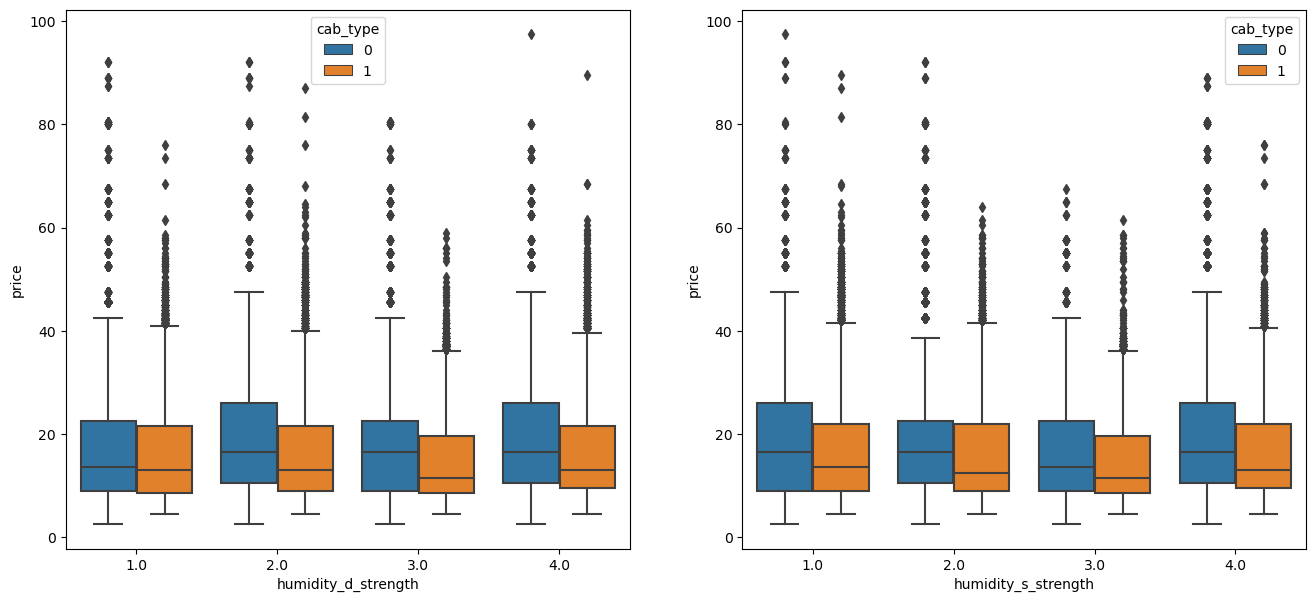

In [79]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_s_strength', y = 'price', hue = 'cab_type')

#### 3 levels of strength...

In [92]:
# humidity source 
train.loc[train['humidity_source'] < hd25, 'humidity_s_strength_3'] = 1
train.loc[((train['humidity_source'] < hd75) & (train['humidity_source'] >= hd15)), 'humidity_s_strength_3'] = 2
train.loc[train['humidity_source'] >= hd75, 'humidity_s_strength_3'] = 3

<AxesSubplot:xlabel='humidity_s_strength_3', ylabel='price'>

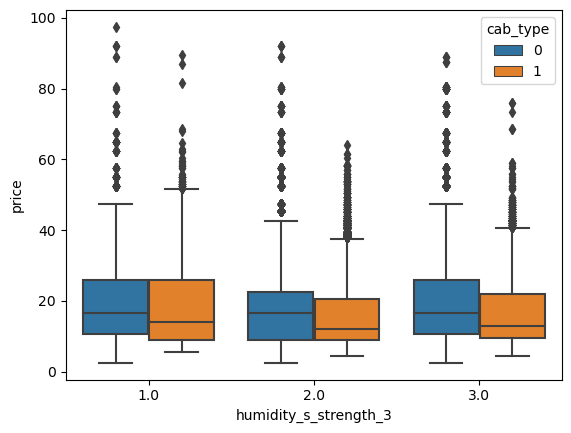

In [93]:
sns.boxplot(data = train, x = 'humidity_s_strength_3', y = 'price', hue = 'cab_type')

#### conclusion: no strong correlation, could keep trying dif strength categories (not just sticking to 25, 50, 75 percentile. but doesn't seem like strong relationship. but again, uber is in general priced lower

### looking at interaction between humidity and rain

## 